# Milestone Project 1: Food Vision Big

## Check GPU

Check if the GPU is compatible with mix precision training.

Google Colab offers:
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

Knowning this, in order to use mixed precision training we need a GPU score of a 7.0+

In [1]:
!nvidia-smi -L

GPU 0: Quadro P2000 (UUID: GPU-45eb6a28-8b9a-6cc9-5299-32453fd1cd04)


## Get helper functions

In past modules, we've created a bunch of helper functions to do small tasks.

Rather than rewrite all of these, we can import a script and load them into our notebook

In [2]:
# Import helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

If you want to get an overview of TensorFlow Datasets (TFDS), read the [guide](https://www.tensorflow.org/datasets/overview)

In [3]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [4]:
# List all avaiable datasets
datasets_list = tfds.list_builders() # get all available datasests in TFDS
print("food101" in datasets_list) # is our target dataset in the list of TFDS?

True


In [5]:
# Load in the data
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train","validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in a tuple format (data,label)
                                             with_info=True)                                             

## Exploring the Food101 data from TensorFlow DataSets

To become one with our data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot-encoded?)
* Do the labels match up with the class names?


In [6]:
# Features of Food101
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [8]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [12]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor,label)

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [13]:
# What does one sample look like?
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [34]:
# Output info about our training sample
for image, label in train_one_sample:
    print(f""""
    Image Shape: {image.shape}
    Image Datatype: {image.dtype}
    Target class from Food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}
    """)

"
    Image Shape: (512, 512, 3)
    Image Datatype: <dtype: 'uint8'>
    Target class from Food101 (tensor form): 23
    Class name (str form): churros
    


In [35]:
# What does our image tensor from TFDS's Food 101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[189, 165, 121],
        [185, 161, 117],
        [181, 157, 113],
        ...,
        [111,  72,  33],
        [103,  64,  25],
        [ 94,  55,  16]],

       [[186, 162, 118],
        [183, 159, 115],
        [180, 156, 112],
        ...,
        [122,  83,  40],
        [113,  74,  31],
        [105,  66,  23]],

       [[180, 156, 112],
        [178, 154, 110],
        [177, 153, 109],
        ...,
        [132,  94,  45],
        [124,  87,  35],
        [120,  83,  31]],

       ...,

       [[207, 204, 159],
        [205, 201, 154],
        [204, 196, 147],
        ...,
        [231, 225, 191],
        [231, 225, 189],
        [231, 226, 188]],

       [[207, 204, 159],
        [205, 201, 154],
        [204, 196, 147],
        ...,
        [230, 224, 190],
        [230, 224, 188],
        [229, 223, 187]],

       [[206, 203, 158],
        [204, 200, 153],
        [203, 195, 146],
        ...,
        [229, 223, 18

In [36]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image),tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow Datasets

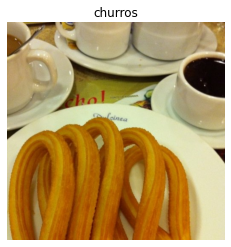

In [37]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create preprocessing functions for our data

Neural networks perform beset when data is in a certain way (e.g. batched, normalized, etc).

However, not all data comes likes this.

So, in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data:
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 - 255)

What we know models like:
* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches, TF likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called normalized tensors generally perform better

Since we are going to be using an EfficientNetBX pretrained model from `tf.keras.applications` we don't need to rescale our data (these architectures have rescaling built-in).

This means our function needs to:
1. Reshape our images to all the same size
2. Convert the dtype from `uint8` to `float32`

In [38]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    # image = image/255. (for models that need normalization)
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [39]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image,label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape}, \nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}..., \nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}\n")

Image before preprocessing:
 [[[189 165 121]
  [185 161 117]
  [181 157 113]
  ...
  [111  72  33]
  [103  64  25]
  [ 94  55  16]]

 [[186 162 118]
  [183 159 115]
  [180 156 112]
  ...
  [122  83  40]
  [113  74  31]
  [105  66  23]]]..., 
Shape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[184.91327  160.91327  116.91326 ]
  [180.35715  156.35715  112.35714 ]
  [183.71428  160.71428  118.71429 ]
  ...
  [147.5915   108.66289   69.08129 ]
  [123.576454  84.576454  44.198887]
  [106.44359   67.44359   25.872158]]

 [[174.66837  150.66837  106.668365]
  [175.14285  151.14285  107.14286 ]
  [177.80103  153.22958  112.015305]
  ...
  [155.61722  119.545784  68.443695]
  [145.1989   108.19381   53.423363]
  [134.37747   98.30605   40.73462 ]]]..., 
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>



## Batch and prepare datasets

We are now going to make our data input pipeline run fast.

For more resources, reference the following [guide](https://www.tensorflow.org/guide/data_performance)

In [41]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to testing
test_data = test_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [42]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

> "Hey, TensorFlow, map this preprocessing function (`preprocess_img`) across our training dataset, then shuffle a number of elements and then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch." 

## Create modelling callbacks

We are going to create callbacks to help us while our model trains:
* TensorBoard callback to log training results
* ModelCheckpoint callback to save our model's progress after feature extraction

In [44]:
# Create tensorboard callback
from helper_functions import create_tensorboard_callback

# Create a ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0) # dont print whether or not model is being saved

## Setup mixed precision training

Mixed precision utilizes a combination of float32 and float16 datatypes to speed up model performance

In [47]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed float 16

In [48]:
!nvidia-smi

Tue Dec 27 10:02:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 517.37       Driver Version: 517.37       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P2000       WDDM  | 00000000:01:00.0  On |                  N/A |
| 52%   45C    P8     5W /  75W |   4929MiB /  5120MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [49]:
mixed_precision.global_policy()

<Policy "mixed_float16">